# Swan Consulting Project
# Feature Engineering and Model Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.metrics\
import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn import tree
# from sklearn.ensemble import BaggingClassifier

In [2]:
# Reading in the data file

df = pd.read_excel('customer_churn.xlsx')

In [3]:
# Removing empty values from the total charges and replacing them with 0
# These are all new customers so we know the charges much currently be 0
# The NaN values haven't imported properly from excel

df['Total Charges'] = df['Total Charges'].replace(' ', 0.0)
df['Total Charges'] = df['Total Charges'].astype(float)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
df_not_churners = df[df['Churn Value'] == 0 ].copy()
df_not_churners

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
1869,7590-VHVEG,1,United States,California,Los Angeles,90001,"33.973616, -118.24902",33.973616,-118.249020,Female,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,NaN
1870,5575-GNVDE,1,United States,California,Los Angeles,90002,"33.949255, -118.246978",33.949255,-118.246978,Male,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,NaN
1871,7795-CFOCW,1,United States,California,Los Angeles,90004,"34.076259, -118.310715",34.076259,-118.310715,Male,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,NaN
1872,1452-KIOVK,1,United States,California,Los Angeles,90007,"34.027337, -118.28515",34.027337,-118.285150,Male,...,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No,0,NaN
1873,6713-OKOMC,1,United States,California,Los Angeles,90008,"34.008293, -118.346766",34.008293,-118.346766,Female,...,No,No,Month-to-month,No,Mailed check,29.75,301.90,No,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,0,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,NaN


Functions for the feature engineering

In [6]:
# Function : to convert all 'yes' and 'no' columns into binary 1:0 columns
def one_zero (x):
    if x == 'Yes':
        return 1
    else:
        return 0


Feature engineering

In [7]:
def feature_eng (df):
    ''' Feature Engineer Function - dropping columns, Changing 'yes' + 'no' columns to binary,
    Changing gender to binary, One Hot encoding of columns'''
    # Making gender binary
    df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})

    # Replacing the No Phone Service value with the No vlaue as these are exactly the same
    df['Multiple Lines'] = df['Multiple Lines'].replace('No Phone Service', 'No')

    # Dropping columns that will be will not be useful to input into our model
    #df.drop(columns = ['Country', 'Count', 'State', 'Lat Long', 'Churn Label'], inplace = True)

    # One hot encoding columns
    df = pd.get_dummies(data = df, columns = ['Internet Service'], drop_first=True, prefix = 'Internet_Service')
    df = pd.get_dummies(data = df, columns = ['Contract'], drop_first=True, prefix = 'Contact')
    df = pd.get_dummies(data = df, columns = ['Payment Method'], drop_first=True, prefix = 'Payment Method')

    # Applying the one_zero function to columns to make them binary
    col_list = ['Senior Citizen','Partner','Dependents','Phone Service', 'Paperless Billing','Online Security',
                'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Multiple Lines']
    for col in col_list:
        df[col] = df[col].apply(one_zero)


    # Scaling columns
    scaled_df = df[['Tenure Months', 'Monthly Charges', 'Total Charges']].copy()
    st_scaler = StandardScaler()
    df_fitted = st_scaler.fit_transform(scaled_df)
    df_scaled = pd.DataFrame(df_fitted, columns=scaled_df.columns)
    df.reset_index(inplace=True)
    df['Tenure Months'] = df_scaled['Tenure Months']
    df['Monthly Charges'] = df_scaled['Monthly Charges']
    df['Total Charges'] = df_scaled['Total Charges']
    df.set_index('index', inplace=True)

    return df

In [8]:
# Creating the Feature_cols list for the model

feature_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
                'Phone Service', 'Multiple Lines', 'Internet Service',
                'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
                'Payment Method', 'Monthly Charges', 'Total Charges']

dataframe = df[feature_cols].copy()
y = df['Churn Value'].copy()

# Splitting my dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(dataframe, y, test_size = 0.2, random_state = 42)

In [9]:
df_model_train = feature_eng(X_train)

In [10]:
X_train.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
2142,1,No,Yes,No,71,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),98.65,6962.85
1623,0,No,No,No,16,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),93.20,1573.70
6074,0,No,No,No,32,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),104.05,3416.85
1362,0,Yes,Yes,No,24,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),40.65,933.30
6754,0,No,Yes,Yes,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,406.05


In [11]:
# Safety check for nulls
df_model_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  5634 non-null   int64  
 1   Senior Citizen                          5634 non-null   int64  
 2   Partner                                 5634 non-null   int64  
 3   Dependents                              5634 non-null   int64  
 4   Tenure Months                           5634 non-null   float64
 5   Phone Service                           5634 non-null   int64  
 6   Multiple Lines                          5634 non-null   int64  
 7   Online Security                         5634 non-null   int64  
 8   Online Backup                           5634 non-null   int64  
 9   Device Protection                       5634 non-null   int64  
 10  Tech Support                            5634 non-null   in

In [12]:
# Data sanity check
df_model_train.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,...,Paperless Billing,Monthly Charges,Total Charges,Internet_Service_Fiber optic,Internet_Service_No,Contact_One year,Contact_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
index,,,,,,,,,,,,,,,,,,,,,
2142,1,0,1,0,1.570886,1,1,0,0,1,...,1,1.133166,2.070847,1,0,1,0,1,0,0
1623,0,0,0,0,-0.669405,1,0,0,1,1,...,1,0.952708,-0.310095,1,0,0,0,1,0,0
6074,0,0,0,0,-0.017684,1,1,0,1,1,...,1,1.311969,0.504214,1,0,1,0,1,0,0
1362,0,1,1,0,-0.343545,0,0,0,0,1,...,1,-0.787308,-0.593026,0,0,0,0,1,0,0
6754,0,0,1,1,-0.506475,1,0,0,0,0,...,0,-1.469407,-0.825967,0,1,0,0,0,0,1


## Logistic Regression Model

In [13]:
lr = LogisticRegression(max_iter=110, random_state = 10)
lr.fit(df_model_train, y_train)

LogisticRegression(max_iter=110, random_state=10)

In [14]:
def results(X, y_split, model, threshold = False, suppress_output = False):
    """Results function calculates the accuracy,precision,recall,f1 scores for the specific model required"""

    df_model = X.copy()
    y = y_split

    probs = pd.DataFrame()
    probs['pred'] = model.predict(df_model)
    df_model[['prob_notchurn', 'prob_churn']] = model.predict_proba(df_model)
    df_model['cutoff_pred'] = np.where(df_model['prob_churn'] > threshold, 1, 0)


    if not threshold:
        accuracy = accuracy_score(y, probs["pred"])
        recall = recall_score(y, probs["pred"])
        precision = precision_score(y, probs["pred"])
        f1 = f1_score(y, probs["pred"])
        confusion = confusion_matrix(y, probs["pred"])
    else:
        accuracy = accuracy_score(y, df_model["cutoff_pred"])
        recall = recall_score(y, df_model["cutoff_pred"])
        precision = precision_score(y, df_model["cutoff_pred"])
        f1 = f1_score(y, df_model["cutoff_pred"])
        confusion = confusion_matrix(y, df_model["cutoff_pred"])

    if not suppress_output:
        print(f'Accuracy of model is {accuracy}')
        print(f'recall {recall}')
        print(f'precision {precision}')
        print(f'F1 {f1}')
        print(f'confusion matrix: \n {confusion}')

    return accuracy,precision,recall,f1


In [15]:
results(df_model_train, y_train, lr)

Accuracy of model is 0.8170039048633297
recall 0.5793056501021103
precision 0.6732594936708861
F1 0.6227588730332968
confusion matrix: 
 [[3752  413]
 [ 618  851]]


(0.8170039048633297,
 0.6732594936708861,
 0.5793056501021103,
 0.6227588730332968)

In [16]:
df_model_test = feature_eng(X_test)

In [17]:
results(df_model_test, y_test,lr)

Accuracy of model is 0.8034066713981547
recall 0.57
precision 0.6846846846846847
F1 0.6221009549795361
confusion matrix: 
 [[904 105]
 [172 228]]


(0.8034066713981547, 0.6846846846846847, 0.57, 0.6221009549795361)

In [22]:
# The metric values for different cutoffs
cut = []
acc = []
pre = []
rec = []
fs = []
for cutoff in np.arange(0.1,0.875,0.025):
    m1,m2,m3,m4 = results(df_model_train, y_train, lr, cutoff, suppress_output=True)
    cut.append(cutoff)
    acc.append(m1)
    pre.append(m2)
    rec.append(m3)
    fs.append(m4)

logreg_cutoff_df = pd.DataFrame({'cutoff':cut,'accuracy':acc,'precision':pre,'recall':rec,'f1_score':fs})
logreg_cutoff_df

,cutoff,accuracy,precision,recall,f1_score
0,0.100,0.633120,0.411486,0.946222,0.573551
1,0.125,0.666489,0.434588,0.927161,0.591788
2,0.150,0.689208,0.452171,0.907420,0.603577
3,0.175,0.705360,0.466002,0.891082,0.611968
4,0.200,0.723465,0.483315,0.877468,0.623308
5,0.225,0.741037,0.502016,0.847515,0.630539
6,0.250,0.753639,0.517315,0.823690,0.635504
7,0.275,0.768016,0.536751,0.805310,0.644160
8,0.300,0.780795,0.556467,0.784888,0.651228
9,0.325,0.783635,0.563387,0.756297,0.645743


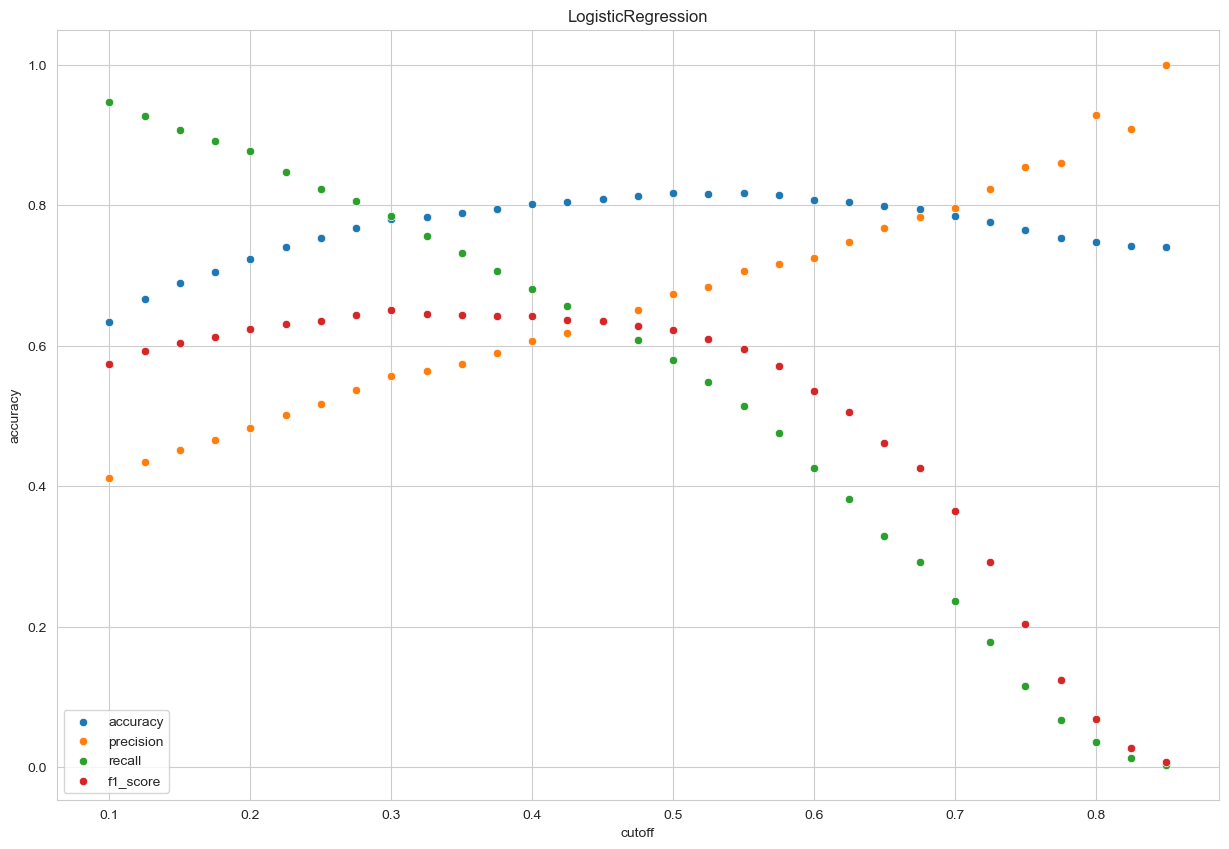

In [23]:
plt.figure(figsize=(15,10))
for y_axis in ['accuracy','precision','recall','f1_score']:
    sns.scatterplot(data=logreg_cutoff_df,x='cutoff',y=y_axis)

plt.legend(['accuracy','precision','recall','f1_score'])
plt.title('LogisticRegression')
plt.show()

In [19]:
results(df_model_test, y_test, lr, 0.45);

Accuracy of model is 0.8019872249822569
recall 0.635
precision 0.6563307493540051
F1 0.6454891994917408
confusion matrix: 
 [[876 133]
 [146 254]]


## Decision Trees Model

In [24]:
gsdt = GridSearchCV(estimator = tree.DecisionTreeClassifier(random_state=10),
                    param_grid = {'max_depth': [3, 5, 7, 10, 20],
                                  'min_samples_split': [5, 10, 15, 20, 50, 100],
                                  'min_samples_leaf': [2, 5, 6, 20, 50, 100]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    n_jobs=5,
                    scoring = 'accuracy')


In [25]:
gsdt.fit(df_model_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10), n_jobs=5,
             param_grid={'max_depth': [3, 5, 7, 10, 20],
                         'min_samples_leaf': [2, 5, 6, 20, 50, 100],
                         'min_samples_split': [5, 10, 15, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [30]:
gsdt.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 100}

In [57]:

dt = tree.DecisionTreeClassifier(max_depth= 5, min_samples_leaf=20, min_samples_split=100, random_state=10)
# Max depth = 100, min_samples_leaf = 5, min_samples_split = 20

##
dt.fit(df_model_train, y_train)

##
dt.score(df_model_test, y_test)

0.7920511000709723

In [58]:
dt.classes_

array([0, 1], dtype=int64)

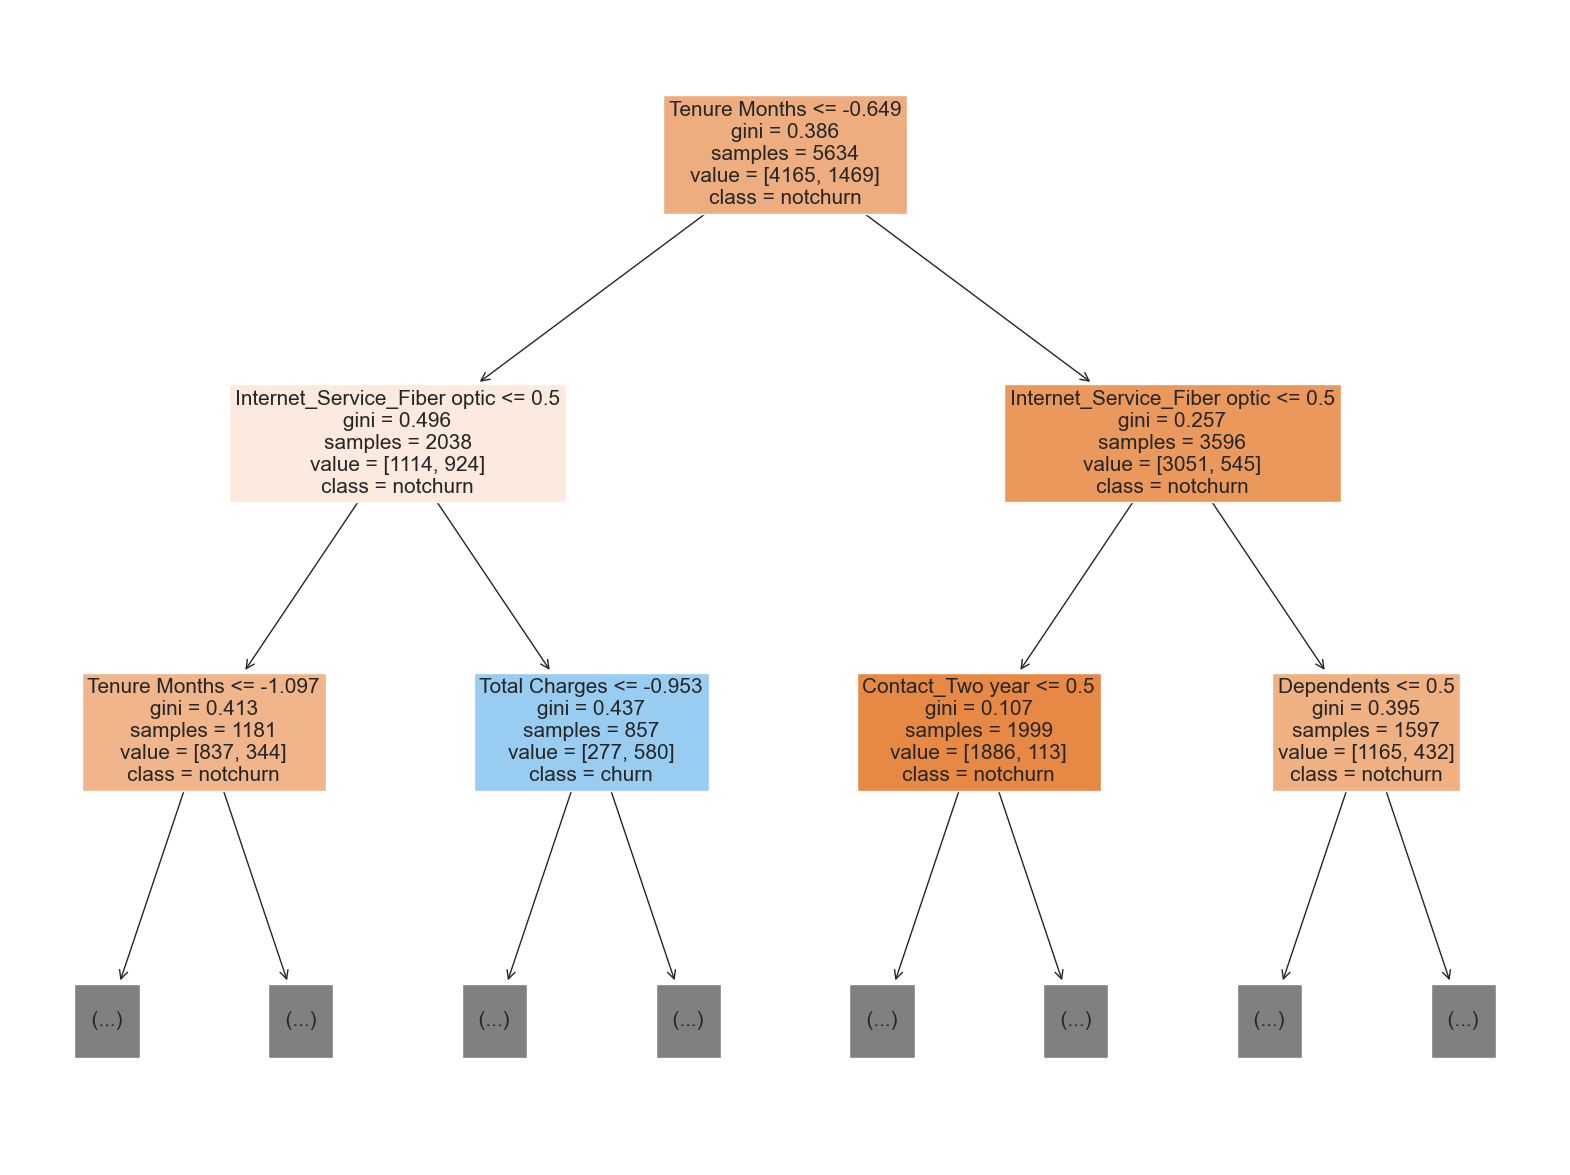

In [63]:
fig = plt.figure(figsize=(20,15))
thing = tree.plot_tree(dt,
                       feature_names=df_model_train.columns, max_depth=2,
                       class_names=['notchurn', 'churn'], filled=True, fontsize = 15)

In [65]:
results(df_model_test, y_test,dt);

Accuracy of model is 0.7920511000709723
recall 0.6125
precision 0.639686684073107
F1 0.6257982120051085
confusion matrix: 
 [[871 138]
 [155 245]]


## Random Forest Model

In [31]:
gscv = GridSearchCV(estimator = RandomForestClassifier(random_state=10),
                    param_grid = {'max_depth': [2, 3, 5, 7, 10],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'n_estimators': [2, 5, 10, 15, 20, 50, 100, 200],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7]},
                    cv = 10,
                    refit = True,
                    verbose = 1,
                    n_jobs = 5,
                    scoring = 'accuracy')

In [32]:
now = time()

gscv.fit(df_model_train, y_train)

print(f' Time in seconds: {time() - now}')

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
 Time in seconds: 259.41407465934753


In [33]:
gscv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 100}

In [34]:
gscv.best_score_

0.8086580250179509

In [35]:
rfc = RandomForestClassifier(max_depth=10,min_samples_leaf=5,min_samples_split=20,n_estimators=100, random_state=10)
# rf_score = cross_val_score(rfc, df_model_train, y_train, cv=5)
# print(rf_score)
rfc.fit(df_model_train, y_train)
results(df_model_train, y_train, rfc, 0.43);

Accuracy of model is 0.844337948171814
recall 0.6943498978897209
precision 0.7044198895027625
F1 0.6993486458690436
confusion matrix: 
 [[3737  428]
 [ 449 1020]]


In [36]:
results(df_model_train, y_train, rfc);

Accuracy of model is 0.8383031593894213
recall 0.562287270251872
precision 0.7550274223034735
F1 0.6445571595786187
confusion matrix: 
 [[3897  268]
 [ 643  826]]


In [38]:
results(df_model_test, y_test, rfc);

Accuracy of model is 0.8062455642299503
recall 0.5175
precision 0.7212543554006968
F1 0.6026200873362445
confusion matrix: 
 [[929  80]
 [193 207]]


In [40]:
# The metric values for different cutoffs
cut = []
acc = []
pre = []
rec = []
fs = []
for cutoff in np.arange(0.1,0.9,0.025):
    m1,m2,m3,m4 = results(df_model_train, y_train, rfc, cutoff, suppress_output=True)
    cut.append(cutoff)
    acc.append(m1)
    pre.append(m2)
    rec.append(m3)
    fs.append(m4)

rfc_cutoff_df = pd.DataFrame({'cutoff':cut,'accuracy':acc,'precision':pre,'recall':rec,'f1_score':fs})
rfc_cutoff_df

,cutoff,accuracy,precision,recall,f1_score
0,0.100,0.619808,0.406398,0.994554,0.577014
1,0.125,0.665957,0.437707,0.987747,0.606605
2,0.150,0.702343,0.466278,0.978897,0.631671
3,0.175,0.727725,0.488774,0.963240,0.648488
4,0.200,0.753284,0.514538,0.951668,0.667941
5,0.225,0.771743,0.535896,0.929884,0.679940
6,0.250,0.789492,0.559032,0.912185,0.693223
7,0.275,0.805822,0.583519,0.891763,0.705439
8,0.300,0.819844,0.609030,0.863172,0.714165
9,0.325,0.827299,0.627572,0.830497,0.714914


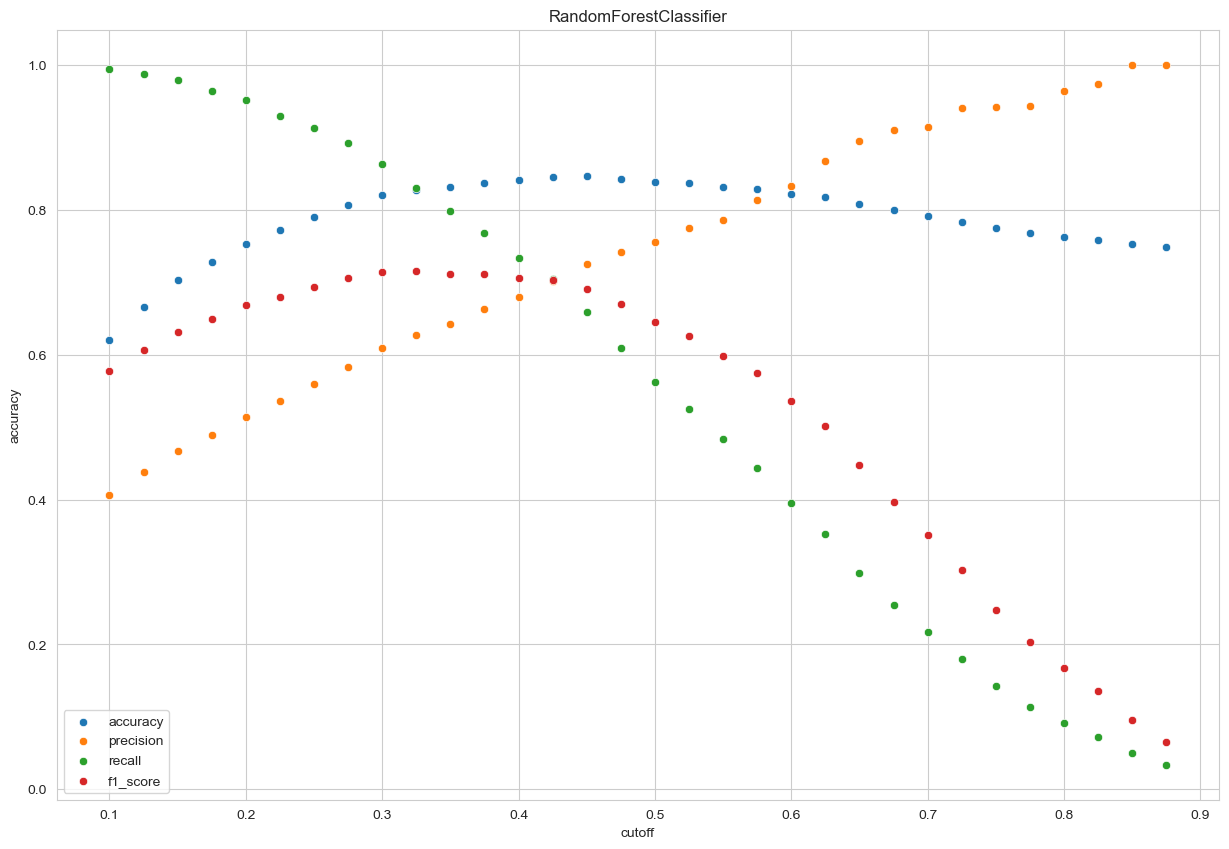

In [41]:
plt.figure(figsize=(15,10))
for y_axis in ['accuracy','precision','recall','f1_score']:
    sns.scatterplot(data=rfc_cutoff_df,x='cutoff',y=y_axis)

plt.legend(['accuracy','precision','recall','f1_score'])
plt.title('RandomForestClassifier')
plt.show()

In [42]:
results(df_model_test,y_test,rfc,0.43);

Accuracy of model is 0.8112136266855926
recall 0.6275
precision 0.6820652173913043
F1 0.6536458333333334
confusion matrix: 
 [[892 117]
 [149 251]]


## Extra Trees Model

In [43]:
et = ExtraTreesClassifier()
et_params = {
    'n_estimators': [10,50,100,200,500,600,700],
    'max_depth': [None,1,2,3,4,5,8,10,15],
}
gs = GridSearchCV(et, param_grid=et_params, cv=5,n_jobs=5,)

gs.fit(df_model_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=5,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 8, 10, 15],
                         'n_estimators': [10, 50, 100, 200, 500, 600, 700]})

In [44]:
gs.best_params_

{'max_depth': 8, 'n_estimators': 200}

In [45]:
et = ExtraTreesClassifier(max_depth=10, n_estimators=700)

et.fit(df_model_train, y_train)

et.score(df_model_test, y_test)

0.8062455642299503

In [66]:
# The metric values for different cutoffs
cut = []
acc = []
pre = []
rec = []
fs = []
for cutoff in np.arange(0.1,0.85,0.025):
    m1,m2,m3,m4 = results(df_model_train, y_train, et, cutoff, suppress_output=True)
    cut.append(cutoff)
    acc.append(m1)
    pre.append(m2)
    rec.append(m3)
    fs.append(m4)

et_cutoff_df = pd.DataFrame({'cutoff':cut,'accuracy':acc,'precision':pre,'recall':rec,'f1_score':fs})
et_cutoff_df

,cutoff,accuracy,precision,recall,f1_score
0,0.100,0.639333,0.419548,0.999319,0.590982
1,0.125,0.677139,0.446646,0.997277,0.616972
2,0.150,0.710330,0.473633,0.996596,0.642105
3,0.175,0.737487,0.498289,0.991150,0.663175
4,0.200,0.769258,0.531009,0.985024,0.690033
5,0.225,0.790380,0.555814,0.976174,0.708323
6,0.250,0.813277,0.587421,0.953710,0.727037
7,0.275,0.827831,0.609767,0.943499,0.740780
8,0.300,0.839013,0.630941,0.921715,0.749101
9,0.325,0.851083,0.655786,0.902655,0.759668


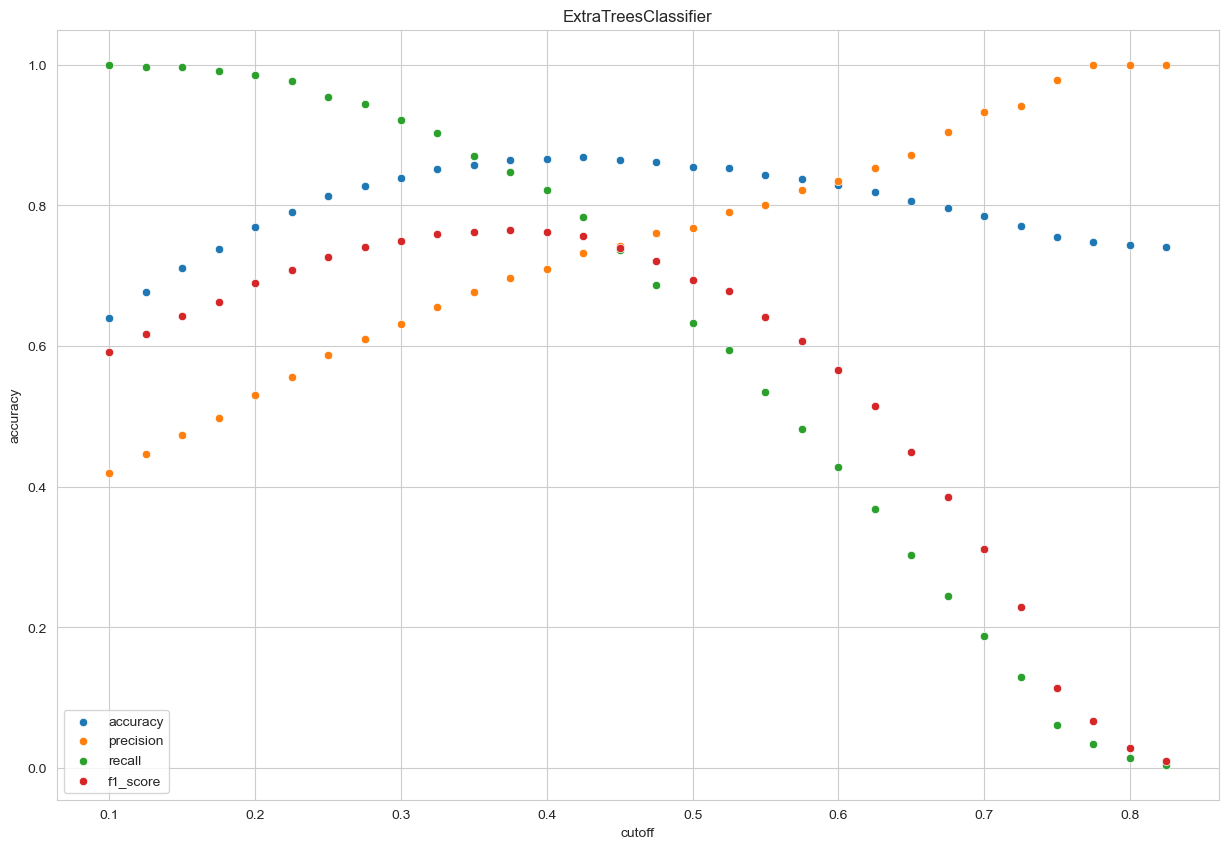

In [67]:
plt.figure(figsize=(15,10))
for y_axis in ['accuracy','precision','recall','f1_score']:
    sns.scatterplot(data=et_cutoff_df,x='cutoff',y=y_axis)

plt.legend(['accuracy','precision','recall','f1_score'])
plt.title('ExtraTreesClassifier')
plt.show()

## Applying the Logistic Regression Model

Applying the model on the list of customers who have not churned

In [48]:
final_model_df = feature_eng(df_not_churners[feature_cols].copy())

In [49]:
final_model_df.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,...,Paperless Billing,Monthly Charges,Total Charges,Internet_Service_Fiber optic,Internet_Service_No,Contact_One year,Contact_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
index,,,,,,,,,,,,,,,,,,,,,
1869,0,0,1,0,-1.516706,0,0,0,1,0,...,1,-1.010469,-1.081697,0,0,0,0,0,1,0
1870,1,0,0,0,-0.148061,1,0,1,0,1,...,0,-0.138796,-0.283471,0,0,1,0,0,0,1
1871,1,0,0,0,0.308154,0,0,1,0,1,...,0,-0.610014,-0.304397,0,0,1,0,0,0,0
1872,1,0,0,1,-0.645750,1,1,0,1,0,...,1,0.895310,-0.257760,1,0,0,0,1,0,0
1873,0,0,0,0,-1.143439,0,0,1,0,0,...,0,-1.013686,-0.964924,0,0,0,0,0,0,1


In [50]:
df_not_churners.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
1869,7590-VHVEG,1,United States,California,Los Angeles,90001,"33.973616, -118.24902",33.973616,-118.249020,Female,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,NaN
1870,5575-GNVDE,1,United States,California,Los Angeles,90002,"33.949255, -118.246978",33.949255,-118.246978,Male,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,NaN
1871,7795-CFOCW,1,United States,California,Los Angeles,90004,"34.076259, -118.310715",34.076259,-118.310715,Male,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,NaN
1872,1452-KIOVK,1,United States,California,Los Angeles,90007,"34.027337, -118.28515",34.027337,-118.285150,Male,...,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No,0,NaN
1873,6713-OKOMC,1,United States,California,Los Angeles,90008,"34.008293, -118.346766",34.008293,-118.346766,Female,...,No,No,Month-to-month,No,Mailed check,29.75,301.90,No,0,NaN


In [68]:
probs = lr.predict_proba(final_model_df)
# probs

In [52]:
df_not_churners.reset_index(inplace=True)
df_not_churners[['P_Not Churn','P_Churn']] = probs
df_not_churners.set_index('index', inplace=True)

In [53]:
sorted_list = df_not_churners.sort_values('P_Churn', ascending=False).copy()

In [54]:
sorted_list.head(500)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason,P_Not Churn,P_Churn
index,,,,,,,,,,,,,,,,,,,,,
2567,6630-UJZMY,1,United States,California,Palo Alto,94306,"37.416159, -122.131337",37.416159,-122.131337,Female,...,Month-to-month,Yes,Electronic check,83.25,308.05,No,0,NaN,0.122209,0.877791
3732,4927-WWOOZ,1,United States,California,Pacific Grove,93950,"36.618337, -121.926417",36.618337,-121.926417,Male,...,Month-to-month,Yes,Electronic check,91.45,171.45,No,0,NaN,0.123795,0.876205
4624,3489-HHPFY,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,Month-to-month,Yes,Electronic check,84.05,134.05,No,0,NaN,0.124440,0.875560
4198,5150-ITWWB,1,United States,California,Hamilton City,95951,"39.732767, -122.042298",39.732767,-122.042298,Male,...,Month-to-month,Yes,Electronic check,94.85,335.75,No,0,NaN,0.131009,0.868991
4341,2545-EBUPK,1,United States,California,Los Angeles,90045,"33.954017, -118.402447",33.954017,-118.402447,Female,...,Month-to-month,Yes,Electronic check,84.05,186.05,No,0,NaN,0.148040,0.851960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,1173-NOEYG,1,United States,California,Santa Margarita,93453,"35.303926, -120.256567",35.303926,-120.256567,Female,...,Month-to-month,No,Bank transfer (automatic),90.15,2423.40,No,0,NaN,0.415495,0.584505
5200,3956-MGXOG,1,United States,California,Modesto,95350,"37.671806, -121.007575",37.671806,-121.007575,Female,...,Month-to-month,Yes,Electronic check,80.60,2244.95,No,0,NaN,0.416202,0.583798
6574,2974-GGUXS,1,United States,California,Granite Bay,95746,"38.749466, -121.184196",38.749466,-121.184196,Female,...,Month-to-month,Yes,Credit card (automatic),91.95,3301.05,No,0,NaN,0.416439,0.583561


In [55]:
sorted_list.to_csv('Customer List of Churn Risk.csv')
sorted_list.head(500).to_csv('Customer List of 500 most likely to churn.csv')